# Creation of an artificial neural network from scratch

This notebook currently contains a very basic implementation of an artificial neural network from scratch. 
The first cell contains

1. A definition of several activation functions and their derivatives.
2. A definition of a loss function and its derivative.
3. A definition of the forward propagation through a single layer
4. A definition of a backward propagation through a single layer


Your task is to do the following extentions to the code in this cell:

1. Add support for an additional activation function.
2. Add the use of a bias in the forward- and backward-propagation. 
As it is implemented now, all solutions have to pass the origin.

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(12345) # Set initial random seed (good to always do)



# Activation functions, the parameter f decides which activation function that is used.
# TODO: Add at least one new activation function and its derivative.
def activate(a, f="none"):
    
    if f=="none":
        y = a
    elif f == "relu":
        y = np.maximum(a,0)
    #Sigmoid activation function according to mathematical formula
    elif f == "sigmoid":
        y = 1 / (1 + np.exp(-a))
    return y
    

    
# Derivatives of activation functions
def d_activate(a, f="none"):
    if f=="none":
        dy = np.ones_like(a)
    elif f == "relu":
        dy = 1 * (a > 0)
    #Derivative of sigmoid activation function according to mathematical formula
    elif f == "sigmoid":
        y = 1 / (1 + np.exp(-a))
        dy = y * (1 - y)
    return dy


# This is the loss for a set of predictions y_hat compared to a set of real valyes y
def MSE_loss(y_hat, y):
    return 1/2 * np.mean((y_hat-y)**2)


# This is the derivative of the loss with respect to the predicted value y_hat
def d_MSE_loss(y_hat, y):
    m = y.shape[0]
    return 1./m * (y_hat-y)


# Propagate a signal through a layer in a neueral network.
# TODO: Add support for the use of a bias as well
def propagate_forward(w, a, b, f="none"): #b is bias
    z = activate(np.dot(a,w) + b, f) # add bias to the dot product
    return z
    

# Calculate the backward gradients that are passed throught the layer in the backward pass.
# Returns both the derivative of the loss in respect to the weights w and the input signal a.
# TODO: Add support for a bias as well
def propagate_backward(w, a, b, dl_dz, f="none"): #b is bias
    
    dl = d_activate(np.dot(a,w) + b, f) * dl_dz # add bias to the dot product
    dw = np.dot(a.T, dl)
    da = np.dot(dl, w.T)
    db = np.sum(dl, axis=0) #Gradient of bias
    
    return dw, da, db



## An implementation of a neural network

Below is an implementation of a MLP neural network. This implementation is still lacking several details that are needed for the network to be robust and function well. Your task is to improve it with the following:

1. Add a bias to the activation functions that are fine tuned during training. 
2. Add a function that trains the network using minibatches (the network only trains on a few samples at a time) 
3. Optional: Make use of an validation set in the training function. The model should hence stop training when the loss starts to increase for the validation set.


In [72]:


# A class for a neural network
class NeuralNet(object):
    
    # Setup all parameters and activation functions.
    # TODO: Add support for a bias for each neuron
    def __init__ (self, input_dim, output_dim, neurons, activation = "relu"): #Added activation for hyper-parameter tuning
        
        self.ws = [np.random.normal(0,2,(n,m)) for n,m in
                   zip([input_dim] + neurons, neurons + [output_dim])]
        self.biases = [np.random.normal(0,2,(1,m)) for m in neurons + [output_dim]] #Initialize the biases
        self.activations = [activation] * len(neurons) + ["none"]
    
    
    # Predict the input throught the network and calculate the output.
    # TODO: Add support for a bias for each neuron
    def forward(self, x):
        for w,b,f in zip(self.ws, self.biases, self.activations):
            x = propagate_forward(w,x,b,f)
        return x
    
    
    # Adjust the weights in the network to better fit the desired output (y), given the input (x).
    # alpha is the learning learning.
    # TODO: Add support for a bias for each neuron and make sure these are learnt as well.
    def adjust_weights(self, x, y, alpha=1e-4):
                
        a = x
        al = []
        
        for w,b,f in zip(self.ws, self.biases, self.activations):
            al.append(a)
            a = propagate_forward(w,a,b,f)
           
        
        loss = MSE_loss(a,y)
        da = d_MSE_loss(a,y)

        
        for w,b,f,x in reversed(list(zip(self.ws, self.biases, self.activations, al))):

            dw, da, db = propagate_backward(w,x,b,da,f)
            w -= alpha * dw
            b -= alpha * db #Learn the bias

                        
        return loss
    
    
    # A function for the training of the network.
    # TODO: Add a training loop where the weights and biases of the network is learnt over several epochs.
    # TODO: Add support for mini batches. That is, in each epoch the data should be split into several
    #       smaller subsets and the model should be trained on each of these subsets one at a time.
    # TODO: Optionally split the training data into training data and validation data.
    #       The validation data should be used to stop the training when the model stops to generalise and
    #       starts to overfit.
    def train_net(self, x, y, batch_size=64, epochs=100):
        result = []
        trainSize = x.shape[0]
        for epoch in range(epochs):
            #Shuffle data each epoch
            permutation = np.random.permutation(trainSize)
            x = x[permutation]
            y = y[permutation]

            #Get the number of possible batches with given batch_size, throw the rest
            noOfBatches = trainSize // batch_size

            #Initialize the epoch loss
            epochLoss = 0.0

            for batch in range(noOfBatches):
                start = batch * batch_size
                end = (batch + 1) * batch_size

                xBatch = x[start:end]
                yBatch = y[start:end]

                loss = self.adjust_weights(xBatch, yBatch)
                epochLoss += loss

            #Get the mean loss of every batch every epoch
            epochLoss /= noOfBatches
            result.append(epochLoss)
            #print("epoch " + str(epoch + 1) + "/" + str(epochs) + ", Loss: " + str(loss))

        #Return the epoch losses
        return result

    
    


## Main programs

This cell should contain your different programs. In this cell you should present:

1. At least 3 programs where the neural network is applied to 3 different datasets.
2. You should also have at least 2 programs where you fine tune 2 hyper-parameters.

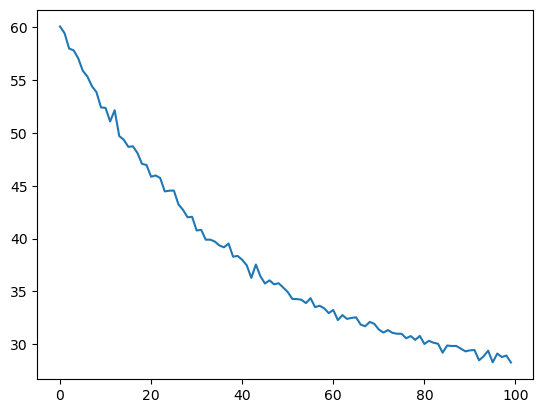

In [73]:
# A simple example program

def main1():
    np.random.seed(1234) # Set initial random seed (good to always do)
    n = 1000
    d = 4

    k = np.random.randint(0,10,(d,1))
    x = np.random.normal(0,1,(n,d))
    y = np.dot(x,k) + 0.1 + np.random.normal(0,0.01,(n,1))
    
                         
    nn = NeuralNet(d, 1, [18, 12], "sigmoid")
    
    result = nn.train_net(x, y)
    plt.plot(result)
    plt.show()

    

main1()

In [1]:
def dataPreparation(dataframe):
    #Get the value types (n or r)
    valueTypes = dataframe.iloc[0].to_numpy()

    #Get columns names for later convenience
    columnNames = dataframe.columns

    #Exclude the value types from the dataframe
    dataframe = dataframe.drop([0])

    for i in range(len(valueTypes)):
        #Check if the column contains nominal values
        if valueTypes[i] == "n":

            #Get all the unique nominal values
            uniqueValues = dataframe.iloc[:, i].unique()

            #Iterate through every unique nominal values
            for j in range(len(uniqueValues)):
                
                #Replace nominal value with an integer indexing (0,1,...,n)
                dataframe.loc[dataframe[columnNames[i]] == uniqueValues[j], columnNames[i]] = j

    #Since every value by this point in numeric, convert all values to float
    dataframe = dataframe.astype(float)

    #Return xTrain and yTrain as ndarrays
    return dataframe.iloc[:,:-1].to_numpy(), dataframe.iloc[:,-1:].to_numpy()


The interval and step-size were kept to their default values when downloading this notebook for the first time. Reasoning being it seemed to give good results, at least with relu as the activation function.
The first choice of hyper-parameter tuning is using different activation functions, reason being to find the superior one and that was the relu activation function.
The second choice of hyper-parameter tuning is using different batch size, reason being seing if the loss decreases at a faster rate. It didn't seem to affect the loss with the relu activation funciton as a hyper-parameter significantly but using lower batch sizes seemed to imporve while using the sigmoid activation function

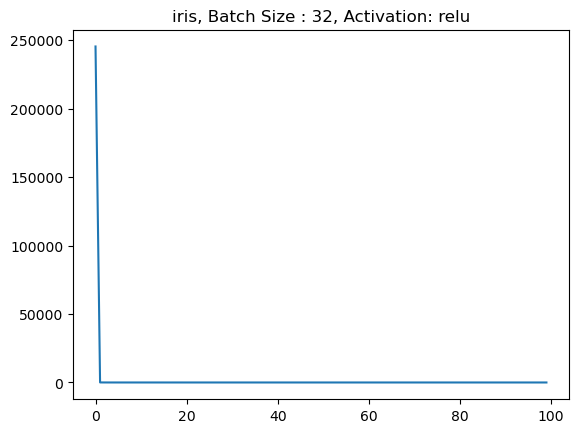

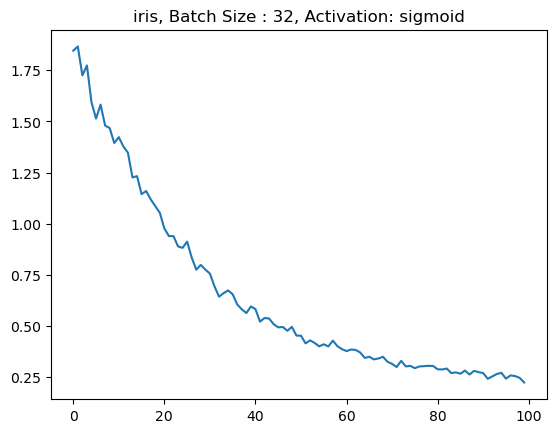

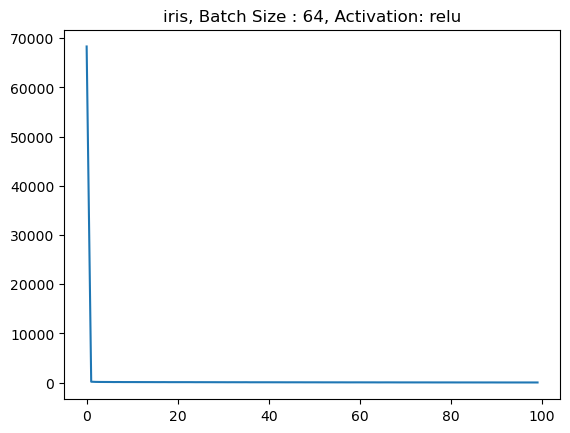

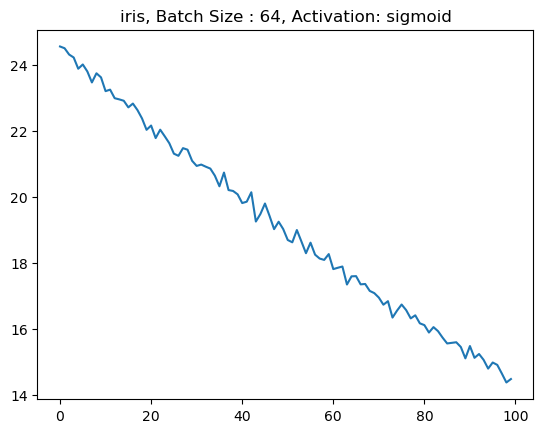

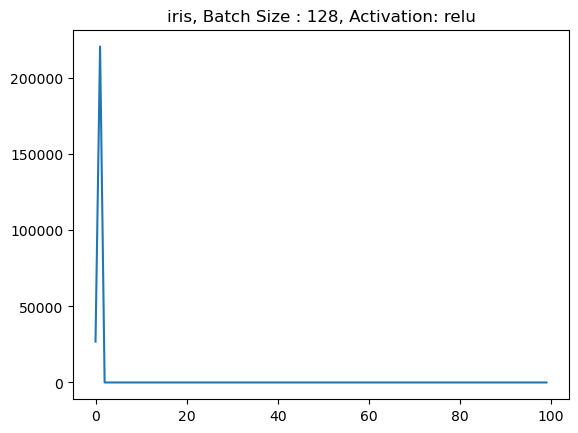

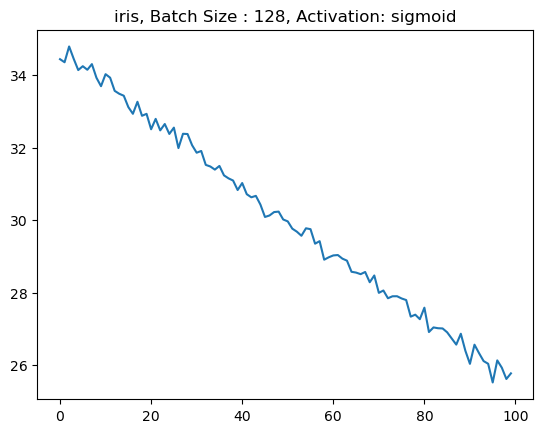

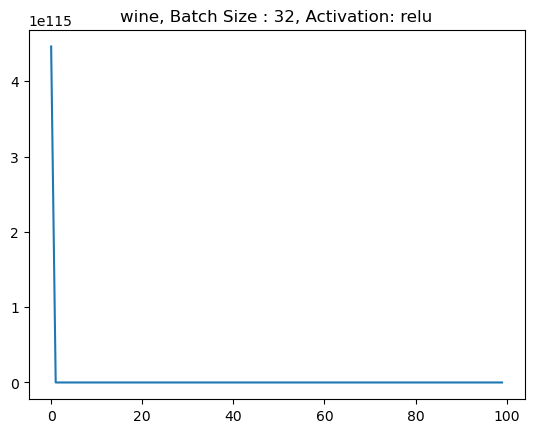

C:\Users\isacs\AppData\Local\Temp\ipykernel_17932\2360051157.py:18: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-a))
C:\Users\isacs\AppData\Local\Temp\ipykernel_17932\2360051157.py:30: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-a))


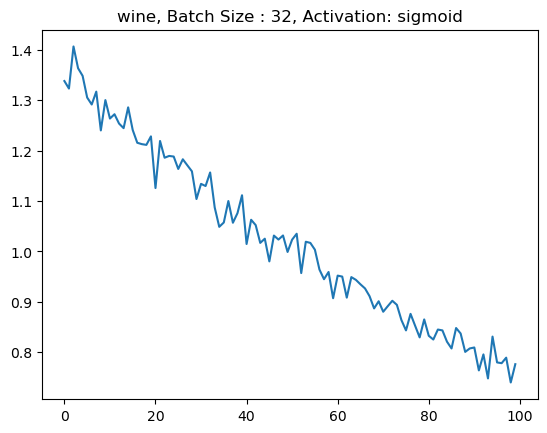

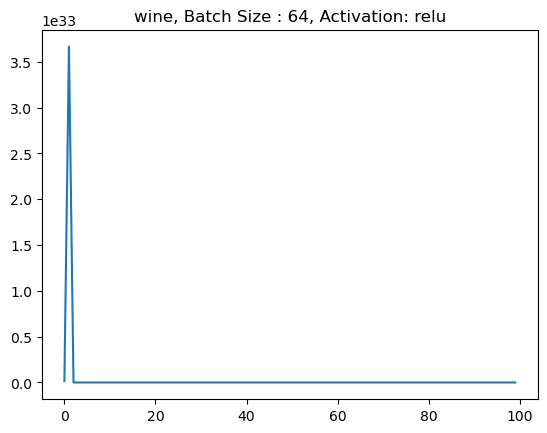

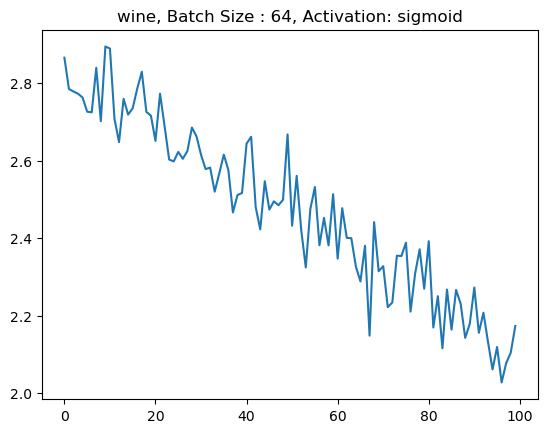

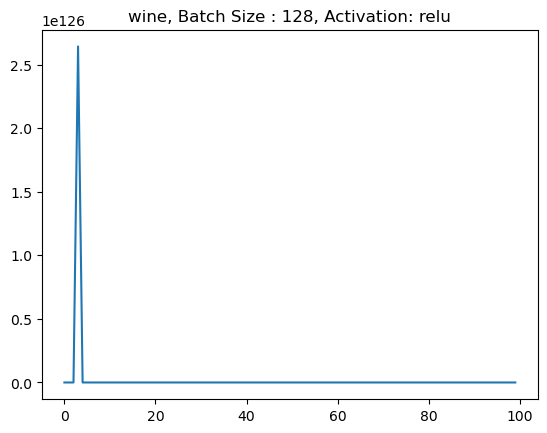

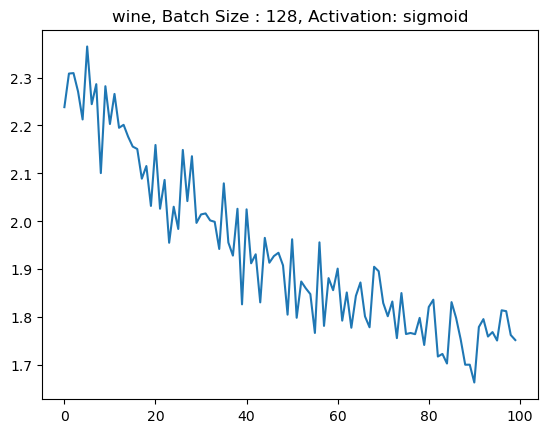

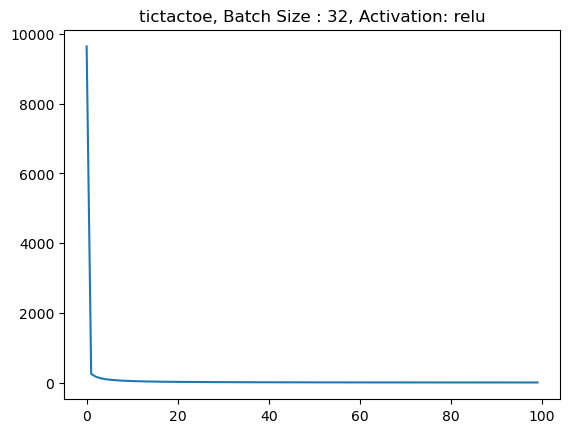

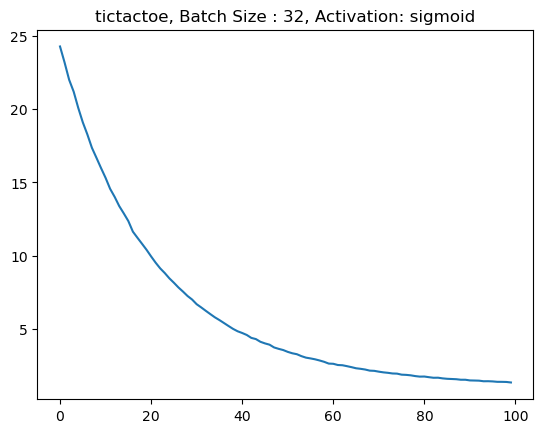

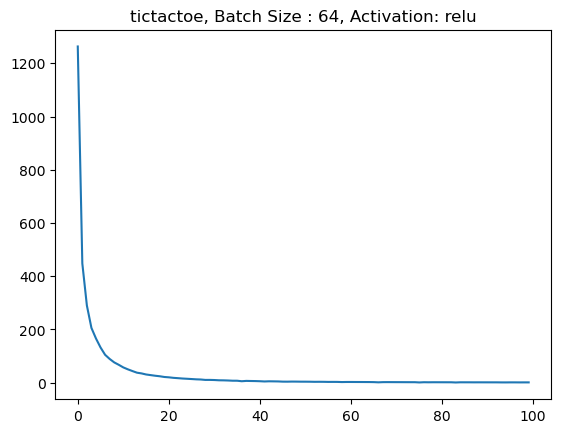

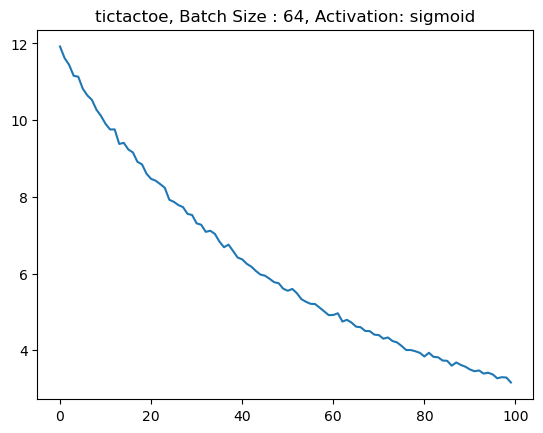

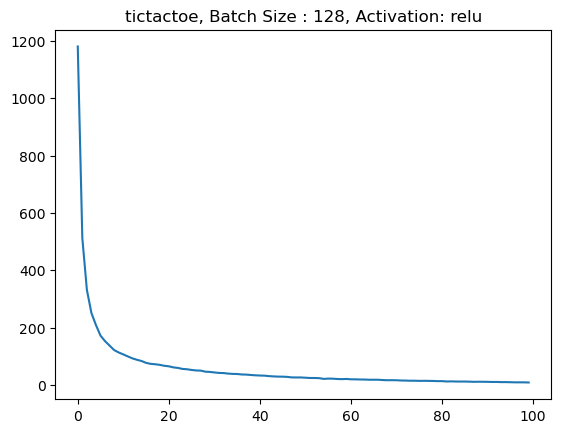

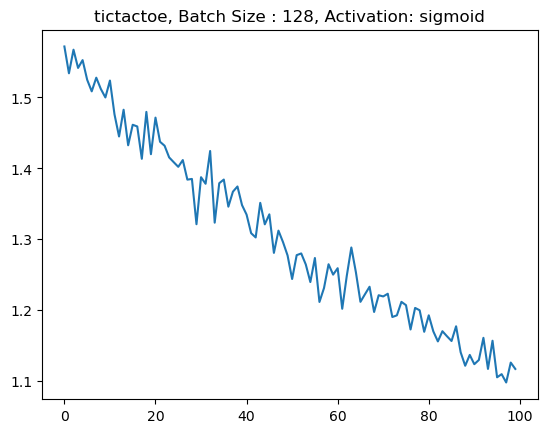

In [80]:
def main2():

    #2 different types of hyper-parameter tuning
    activations = ["relu", "sigmoid"]
    batchSizes = [32, 64, 128]

    #The required three datasets
    dataframeNames = ["iris", "wine", "tictactoe"]
    
    #Run every dataset in the neural network
    for dataframeName in dataframeNames:
        fileName = dataframeName + ".tmls"
        dataframe = pd.read_csv(fileName)
        xTrain, yTrain = dataPreparation(dataframe)

        #Test all different batch sizes for every dataset
        for batchSize in batchSizes:
            #Test all activation functions, not the none, for every dataset for every batch size
            for activation in activations:
                #Initalize the neural network every new run
                nn = NeuralNet(xTrain.shape[1], yTrain.shape[1], [18, 12], activation)
                #Train the neural network
                result = nn.train_net(xTrain, yTrain, batch_size=batchSize)

                #Display the epoch loss as a line plot
                plt.plot(result)
                #Add title to lineplot to compare the datasets and hyper-parameters
                plt.title(dataframeName + ", Batch Size : " + str(batchSize) + ", Activation: " + activation)
                plt.show()
        
main2()